In [1]:
%matplotlib inline

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import imageio
from tqdm import tqdm
import copy
import _pickle as pickle

In [3]:
# matplot parameters
plt.rcParams.update({
    "animation.writer": "ffmpeg",
    "font.family": "serif",  # use serif/main font for text elements
    "font.size": 12,
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "hist.bins": 20, # default number of bins in histograms
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         r'\usepackage{color}',
    ]
})

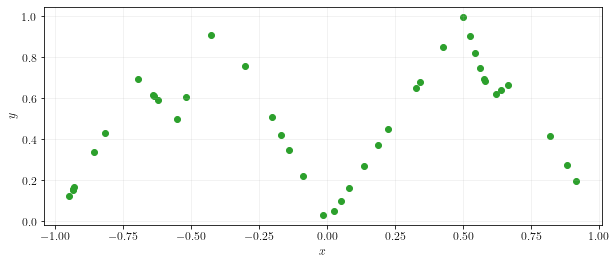

In [4]:
##Data
## no convergence example
x = torch.Tensor(np.array([-0.75,-0.5,0.125]).reshape(-1,1)) 
y = torch.Tensor(np.array([1.1,0.1,0.8]).reshape(-1,1)) 

## Generate Stewart et al. data
x_stew = np.array([-1, -0.7, -0.55, -0.4, 0, 0.5, 0.6, 0.7, 1])
y_stew = np.array([0, 0.7, 0.5, 1, 0, 1, 0.6, 0.7, 0])
x = torch.Tensor(np.random.uniform(-1, 1, 40).reshape(-1,1))
y = torch.Tensor(np.interp(x, x_stew, y_stew))

#############################

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "tab:green")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.grid(alpha=0.2)
#plt.savefig("example.pdf")
#plt.ylim(0,1.2)
plt.show()

## Neural network architecture and initialisation

In [5]:
class Net(torch.nn.Module):
    """
    1 hidden layer Relu network
    """
    def __init__(self, n_feature, n_hidden, n_output, init_scale=1, bias_hidden=True, initialisation='balanced', **kwargs):
        """
        n_feature: dimension of input
        n_hidden: number of hidden neurons
        n_output: dimension of output
        init_scale: all the weights are initialized ~ N(0, init_scale^2/m) where m is the input dimension of this layer
        bias_hidden: if True, use bias parameters in hidden layer. Use no bias otherwise
        bias_output: if True, use bias parameters in output layer. Use no bias otherwise
        intialisation: 'balanced', 'unbalanced' or 'dominated'
                            - balanced ensures ||w_j|| = |a_j|
                            - unbalanced ensures no relation and independently initialise gaussian weights
                            - dominated ensures |a_j| > ||w_j||
        """
        super(Net, self).__init__()
        self.init_scale = init_scale/np.sqrt(n_hidden) # normalisation by sqrt(m)
        self.initialisation_ = initialisation
        
        self.hidden = torch.nn.Linear(n_feature, n_hidden, bias=bias_hidden)   # hidden layer with rescaled init

        self.predict = torch.nn.Linear(n_hidden, n_output, bias=False)   # output layer with rescaled init
        
        if initialisation=='balanced': # balanced initialisation
            torch.nn.init.normal_(self.hidden.weight.data, std=self.init_scale)
            if bias_hidden:
                torch.nn.init.normal_(self.hidden.bias.data, std=self.init_scale)
                neuron_norms = (self.hidden.weight.data.norm(dim=1).square()+self.hidden.bias.data.square()).sqrt()
            else:
                neuron_norms = (self.hidden.weight.data.norm(dim=1).square()).sqrt()
            self.predict.weight.data = 2*torch.bernoulli(0.5*torch.ones_like(self.predict.weight.data)) -1
            self.predict.weight.data *= neuron_norms
            
        if initialisation=='unbalanced':
            torch.nn.init.normal_(self.hidden.weight.data, std=self.init_scale)
            if bias_hidden:
                torch.nn.init.normal_(self.hidden.bias.data, std=self.init_scale)
            torch.nn.init.normal_(self.predict.weight.data, std=self.init_scale)
            
        if initialisation=='dominated':
            torch.nn.init.uniform_(self.hidden.weight.data, a=-self.init_scale, b=self.init_scale)
            self.predict.weight.data = 2*torch.bernoulli(0.5*torch.ones_like(self.predict.weight.data)) -1
            self.predict.weight.data *= self.init_scale
            if bias_hidden:
                torch.nn.init.uniform_(self.hidden.bias.data, a=-self.init_scale, b=self.init_scale)
                self.predict.weight.data *= np.sqrt(2)
            
        self.activation = kwargs.get('activation', torch.nn.ReLU()) # activation of hidden layer
        
        if kwargs.get('zero_output', False):
            # ensure that the estimated function is 0 at initialisation
            # useful when initialising in lazy regime
            half_n = int(n_hidden/2)
            self.hidden.weight.data[half_n:] = self.hidden.weight.data[:half_n]
            if bias_hidden:
                self.hidden.bias.data[half_n:] = self.hidden.bias.data[:half_n]
            self.predict.weight.data[0, half_n:] = -self.predict.weight.data[0, :half_n]
            

    def forward(self, z):
        z = self.activation(self.hidden(z))     
        z = self.predict(z)             # linear output
        return z

## Visualisation functions

In [6]:
def multicolor_label(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax: specifies the axes object where the labels should be drawn
    list_of_strings: a list of all of the text items
    list_if_colors: a corresponding list of colors for the strings
    axis:'x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=60)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.27, -0.18),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.10, 0.2), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)


In [35]:
def save_single_frame(fig, arts, frame_number, name="frame", ext="pdf", **kwargs):
    """save a single frame of an animation
    fig: the figure to save
    arts: list of images resulting in the animation
    frame_number: the specific frame to save as a pdf
    ext: extension of the file (pdf, png, svg...). Has to be compatible with matplotlib savefig format
    kwargs: additional arguments to pass to matplotlib.savefig (e.g., dpi)
    """
    # make sure everything is hidden
    for frame_arts in arts:
        for art in frame_arts:
            art.set_visible(False)
    # make the one artist we want visible
    for i in range(len(arts[frame_number])):
        arts[frame_number][i].set_visible(True)
    fig.savefig(name+"_{}.{}".format(frame_number,ext), **kwargs)

## Training

In [ ]:
# parameters for experiments
params = {'n_hidden': 200000,
         'n_iterations':2000000,
         'init_scale':1e-3,
         'initialisation':'unbalanced',
         'learning_rate':0.001}

# init network
net = Net(n_feature=1, n_output=1, bias_hidden=True, **params)     # define the network
 
optimizer = torch.optim.SGD(net.parameters(), lr=params['learning_rate']) #Gradient descent
loss_func = torch.nn.MSELoss(reduction='mean')  # mean squared error

n_samples = x.shape[0]

loss = torch.Tensor(np.array([0]))
previous_loss = torch.Tensor(np.array([np.infty]))

losses = []

# plot parameters
iter_geom = 1.1 #saved frames correspond to steps t=\lceil k^{iter_geom} \rceil for all integers k 
last_iter = 0
frame = 0
nets = []
iters = []

# train the network
for it in tqdm(range(params['n_iterations'])):
    prediction = net(x)
    loss = loss_func(prediction, y) 
    if (it<2 or it==int(last_iter*iter_geom)+1): # save net weights
        nets.append(copy.deepcopy(net))
        iters.append(it)
        last_iter = it
    losses.append(loss.data.numpy())
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # descent step
    
# save last iterate
nets.append(copy.deepcopy(net))
iters.append(it)

## Load from $\texttt{saves}$ folder

When running the experiments from a terminal instead of a notebook, the $\texttt{saves}$ folder is used to save all intermediate networks weights. It is especially useful for long simulations (e.g. generating Figure 3 in the paper).

In [8]:
params = {'n_hidden': 200000}
net = Net(n_feature=1, n_output=1, bias_hidden=True, **params)

x = torch.load('saves/x.pth')
y = torch.load('saves/y.pth')

iters = np.loadtxt('saves/iters.txt', dtype="int")
losses = np.loadtxt('saves/losses.txt')
nets = []

with open("saves/nets.pth","rb") as netfile:
    while True: 
        try:
            net.load_state_dict(pickle.load(netfile))
            nets.append(copy.deepcopy(net))
        except EOFError:
            break

## Evolution of weights

In [11]:
ims = []
fig = plt.figure("Neuron alignment")
plt.ioff()

# Cosmetics
c1 = 'tab:green' # color of left axis
c2 = 'tab:blue' # color of right axis
c3 = 'black'
color_map = {0 : 'firebrick',
             0.5 : 'black',
             1 : 'darkviolet'}

#plt.subplots_adjust(left=0.15, right=0.85)

ax = fig.add_subplot(111, projection='polar') # polar coordinates
ax.set_rorigin(-5e-2) # set inner circle for 0 norm vectors
ax.set_theta_zero_location("E")
ax.yaxis.set_ticklabels([])

##plot vlines for sector delimitations (omitted for Figure 3 plot)
#w = net.hidden.weight.data.detach().numpy().copy().reshape(-1)
#b = net.hidden.bias.data.detach().numpy().copy()
#ax.vlines(np.arctan(1/x)+np.pi/2, 0, np.max(np.sqrt(w**2+b**2)), colors=c1, linestyles='dashed', lw=1)
#ax.vlines(np.arctan(1/x)-np.pi/2, 0, np.max(np.sqrt(w**2+b**2)), colors=c1, linestyles='dashed', lw=1)

##plot point for x_i (omitted for Figure 3 plot)
#ax.scatter(np.arctan(1/x)+np.pi*np.heaviside(-x,0), np.max(np.sqrt(w**2+b**2))*np.ones_like(x), c=c3, marker='+')
#for i, xi in enumerate(x):
    #ax.annotate(r'$x_{{{n}}}$'.format(n=i+1), (np.arctan(1/xi)+np.pi*np.heaviside(-xi,0), np.max(np.sqrt(w**2+b**2))),
                #xytext=(2.5, -2), textcoords='offset points')

#######
for i,net in enumerate(nets):
    w = net.hidden.weight.data.detach().numpy().reshape(-1)
    s = net.predict.weight.data.heaviside(torch.as_tensor(float(0.5))).reshape(-1).numpy().copy()
    b = net.hidden.bias.data.detach().numpy()
    it = iters[i]
    c = [color_map[d] for d in s] # color of stars given their output layer sign
    im = ax.scatter(np.arctan(b/w)+np.pi*np.heaviside(-w,0), np.sqrt(w**2+b**2), animated=True, c=c, marker='*')
    t1 = ax.annotate("iteration: "+str(it),(0.75,0.95),xycoords='figure fraction',annotation_clip=False) # add text
    ims.append([im,t1])
    
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat=False)
plt.close()

In [13]:
ani.save('neuron_alignment.mp4', fps=10, dpi=120) # save animation as video

### Save specific frames

In [30]:
del ani

/Users/etienne/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [33]:
if isinstance(iters, np.ndarray):
    iters = iters.tolist()
#it_to_save = iters[0]
it_to_save = 1999999
frame = iters.index(it_to_save)
save_single_frame(fig, ims, frame, name="frame_alignment", ext="png", dpi=600) # save specific frame of animation as a pdf or png

## Estimated function

In [36]:
ims = []
fig = plt.figure("Estimated function")
plt.ioff()

# Cosmetics
c1 = 'tab:green' # color of left axis
c2 = 'tab:blue' # color of right axis
c3 = 'black'
c4 = 'tab:red'
plot_OLS = False # if True, also plot the OLS estimator
plot_stew = True # if True, also plot the teacher estimator (data of Stewart et al.)

plt.subplots_adjust(left=0.15, right=0.85, bottom=0.15)

ax1 = fig.add_subplot(111)
ax1.set_xlim(-1,1)
#ax1.set_ylim(-0.5,1.5)
ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_xlabel(r'$x$', fontsize=20)
ax1.grid(alpha=0.5)


#######
z = torch.Tensor(np.linspace(-1,1,100).reshape(-1,1))

for i,net in enumerate(nets):
    it = iters[i]
    im1, = ax1.plot(z.data.numpy(), net(z).data.numpy(), '-', c=c2, lw=2, animated=True, label=r'$h_{\theta^t}(x)$') # current estimated function
    t = ax1.annotate("iteration: "+str(it),(0.4,0.95),xycoords='figure fraction',annotation_clip=False) # add text
    if it == 0:
        ax1.scatter(x.data.numpy(), y.data.numpy(), color=c1)
        if plot_OLS:
            ztilde = np.concatenate((np.linspace(-1,1,100),np.ones(100))).reshape(2,100).T
            xtilde = np.concatenate((x,np.ones_like(x)),axis=1)
            beta,_,_,_ = np.linalg.lstsq(xtilde,y,rcond=None)
            ax1.plot(z.data.numpy(), ztilde@beta, '--', dashes=(5, 10), zorder=3, c=c4, lw=1, label=r'$\langle \beta^*,x \rangle$') # plot OLS
        if plot_stew:
            x_stew = np.array([-1, -0.7, -0.55, -0.4, 0, 0.5, 0.6, 0.7, 1])
            y_stew = np.array([0, 0.7, 0.5, 1, 0, 1, 0.6, 0.7, 0])
            ytilde = np.interp(z.data.numpy(), x_stew, y_stew)
            ax1.plot(z.data.numpy(), ytilde, '--', dashes=(5, 10), zorder=3, c=c4, lw=1, label=r'$h_{\theta^*}(x)$') # plot OLS
        ax1.legend(fontsize=14)
    ims.append([im1,t])
    
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat=False)
plt.close()

In [11]:
ani.save('estimated_function.mp4', fps=10, dpi=120) # save animation as .mp4

### Save specific frames

In [37]:
del ani

/Users/etienne/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [42]:
if isinstance(iters, np.ndarray):
    iters = iters.tolist()

it_to_save = iters[73] # the number is the frame number to save
#it_to_save = 0       # the number is the iteration number to save
frame = iters.index(it_to_save)
save_single_frame(fig, ims, frame, name="frame_estim") # save specific frame of animation as a .pdf

In [ ]:
del ani

In [ ]:
it_to_save = iters[-1]
frame = iters.index(it_to_save)
save_single_frame(fig, ims, frame, name="frame_estim_kinks") # save specific frame of animation as a .pdf

## Loss profile

In [ ]:
plt.figure()
plt.plot(losses, lw=3)
plt.ylim(ymin=0)
#plt.xlim(xmin=0, xmax=20000)
plt.ylabel(r'$L(\theta)$',fontsize=20)
plt.xlabel('Iterations', fontsize=20)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('loss_profile.pdf',)
plt.show()